<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/transfer_learning%20MobileNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Last amended: 07th Jan, 2023
# https://www.tensorflow.org/tutorials/images/transfer_learning

Objectives
> Examine and understand the data<br>
> Build an input pipeline, in this case using Keras ImageDataGenerator<br>
>>Compose the model<br>
>>Load in the pretrained base model (and pretrained weights)<br>
>Stack the classification layers on top<br>
>Train the model<br>
>Evaluate model<br>


Note: It appears in this model, learning rate plays a very crucial role. Further, whenever you change any model-compilation parameters, start from %reset point. Deleteing model, re-initializing etc do not appear to help.

## Install software

In [ ]:
# 1.0 Install current tensorflow
!pip install tensorflow==2.10.0

## Call libraries

In [4]:
# 1.1
#%reset
import numpy as np
import pandas as pd

# 1.1.1
import matplotlib.pyplot as plt

# 1.1.2
import tensorflow as tf

# 1.1.3
import PIL
import pathlib,os

In [5]:
# 1.1.4
tf.__version__

'2.9.2'

## Download data

In [6]:
# 2.0 Data URL:

data_url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

In [7]:
# 2.1 Delete any existing data

!rm -rf /root/.keras/datasets

In [8]:
# 2.2 Download now:

data_dir = tf.keras.utils.get_file(origin = data_url, extract= True)
data_dir

68606236/68606236 [==============================] - 5s 0us/step


'/root/.keras/datasets/cats_and_dogs_filtered.zip'

In [9]:
# 2.3 Check data files:

!ls /root/.keras/datasets

cats_and_dogs_filtered	cats_and_dogs_filtered.zip


In [10]:
# 2.3.1 Check data files:

!ls /root/.keras/datasets/cats_and_dogs_filtered

train  validation  vectorize.py


## Examine data

In [11]:
# 2.3.2

data_dir = pathlib.Path("/root/.keras/datasets/cats_and_dogs_filtered")

In [12]:
# 2.3.3 Iterate over data_dir: 

for i in data_dir.iterdir():
  print(i)

/root/.keras/datasets/cats_and_dogs_filtered/train
/root/.keras/datasets/cats_and_dogs_filtered/validation
/root/.keras/datasets/cats_and_dogs_filtered/vectorize.py


In [13]:
# 2.3.4 Check within train:

for j in (data_dir / "train").iterdir():
  print(j)

/root/.keras/datasets/cats_and_dogs_filtered/train/cats
/root/.keras/datasets/cats_and_dogs_filtered/train/dogs


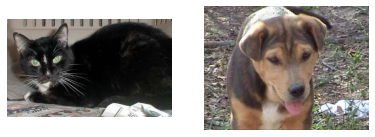

In [14]:
# 3.0 Plot images:

plt.figure(figsize = (10,10))
for k,i in enumerate((data_dir / "train").iterdir()):
  for j in i.iterdir():
    im = PIL.Image.open(j)
    im = np.asarray(im)
    plt.subplot(3,3,k+1)
    plt.imshow(im)
    plt.axis("off")
    break;

## train/test/validation generators

In [15]:
# 3.1 Some constants:

batch_size = 32
image_size = (160,160)

In [16]:
# 3.2 Create train data generator

train_ds = tf.keras.utils.image_dataset_from_directory(data_dir / "train",
                                                       shuffle = True,
                                                       batch_size = batch_size,
                                                       image_size=image_size
                                                       )

Found 2000 files belonging to 2 classes.


In [17]:
# 3.2.1 What are the class names:

train_ds.class_names

['cats', 'dogs']

In [18]:
# 3.3 Validation generator:

valid_ds = tf.keras.utils.image_dataset_from_directory(data_dir / "validation",
                                                       shuffle = True,
                                                       batch_size = batch_size,
                                                       image_size=image_size
                                                       )

Found 1000 files belonging to 2 classes.


In [19]:
# 3.4 How many batches of validation data are possible:

val_batches = tf.data.experimental.cardinality(valid_ds)    # <tf.Tensor: shape=(), dtype=int64, numpy=32> 
                                                            # there are 32 batches; 32 * 32 = 1024
val_batches                                                            

<tf.Tensor: shape=(), dtype=int64, numpy=32>

In [20]:
# 3.5 These are how many batches:

val_batches // 5   # 6

<tf.Tensor: shape=(), dtype=int64, numpy=6>

In [21]:
# 3.6 Just get one batch:

for i,j in valid_ds.take(1):
  print(i.shape)
  print(j.shape)

(32, 160, 160, 3)
(32,)


In [22]:
# 3.7 Take initial val_batches // 5 for test data:

test_dataset = valid_ds.take(val_batches // 5)

In [23]:
#  3.8 tf.data.Dataset.skip() method is used to create a dataset 
#        that skips count initial elements from this dataset.

validation_dataset = valid_ds.skip(val_batches // 5)

In [24]:
# 3.9 Skip example:
#       https://www.tensorflow.org/api_docs/python/tf/data/Dataset#skip

dataset = tf.data.Dataset.range(10)
dataset = dataset.skip(7)
list(dataset.as_numpy_iterator())


[7, 8, 9]

## Prefetching
Configure pre-fetching

### Configure the dataset for performance

In [25]:
# 4.0 Get appropriate buffer size:

buf_size = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size = buf_size)
validation_dataset  = validation_dataset.prefetch(buffer_size = buf_size)
test_dataset = test_dataset.prefetch(buffer_size = buf_size)

## MobileNetV2 model weights

In [26]:
# 4.1 Create the base model from the pre-trained model MobileNet V2

IMG_SHAPE = image_size + (3,)   # (160,160,3)
# What about: f.keras.applications.mobilenet_v2.MobileNetV2
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

type(base_model)  # keras.engine.functional.Functional

9406464/9406464 [==============================] - 0s 0us/step


keras.engine.functional.Functional

## Data augmentation function

In [27]:
# 5.0 Data augmentation function:

data_augmentation = tf.keras.Sequential([
                                          tf.keras.layers.RandomFlip('horizontal'),
                                          tf.keras.layers.RandomRotation(0.2),
                                         ]
                                        )

## Our model

In [28]:
# 6.0 Classification model:
#      Each time you rerun the model, change seed
#       to some other number

# 6.1 Clear existing keras weights from model:
tf.keras.backend.clear_session()
seed = np.round(np.random.random() * 10000 ).astype('int')
tf.random.set_seed(seed)


# 6.2 The model
inputs = tf.keras.Input(shape = IMG_SHAPE )
x = data_augmentation(inputs)   # Note that it is a dequential model
# Rescaling is done by scale*inputs+offset.
# Rescaling(scale=4.0, offset=1.0) implies:
#   [0,255] range it would give 4*[0, 255]+1 = [1, 1021]
x = tf.keras.layers.Rescaling(1./127.5, offset=-1)(x)  # Rescale (-1,1)
# Call the model on new inputs: (x):
# https://www.tensorflow.org/api_docs/python/tf/keras/Model#call
base = base_model(x, training = False)   # No training 
base = tf.keras.layers.Flatten()(base)
base = tf.keras.layers.Dense(256, activation = 'relu')(base)
type(base)
#base = tf.keras.layers.GlobalAveragePooling2D()(base)
#base = tf.keras.layers.Dropout(0.2)(base)
outputs = tf.keras.layers.Dense(1)(base)
md = tf.keras.Model(inputs = [inputs], outputs = [outputs])

See [tf.keras.losses.BinaryCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy)<br>
Als [see](https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow)

> <i>from_logits = True:</i><br>
>> Whether to interpret `y_pred` as a tensor of logit values. By default, we assume that `y_pred` contains probabilities (i.e., values in [0, 1]).

In [58]:
# 6.3 Compile the mode:
#     This compilation gives very good results.
#     But see Note at the beginning.
# Adam: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

base_learning_rate = 0.0001
md.compile(   optimizer=tf.keras.optimizers.Adam(
                                                learning_rate=base_learning_rate   # Default: 0.01
                                                ),
              loss=tf.keras.losses.BinaryCrossentropy(
                                                      from_logits=True  # Default: False
                                                     ),
              metrics=['accuracy']
           )

In [ ]:
# 6.4 This compilation does not give good results: 
md.compile( 
            loss=tf.keras.losses.BinaryCrossentropy(
                                                      from_logits=True  # Default: False
                                                     ),
            optimizer = tf.keras.optimizers.Adam(),
            metrics = ["accuracy"]
           )

## Train model

In [59]:
# 6.5 Train the model:

md.fit(train_ds,
       batch_size = batch_size,
       epochs = 10,
       validation_data = validation_dataset
       )

Epoch 1/10
63/63 [==============================] - 26s 204ms/step - loss: 0.2841 - accuracy: 0.8910 - val_loss: 0.0803 - val_accuracy: 0.9616
Epoch 2/10
63/63 [==============================] - 12s 180ms/step - loss: 0.1761 - accuracy: 0.9280 - val_loss: 0.0445 - val_accuracy: 0.9839
Epoch 3/10
63/63 [==============================] - 12s 180ms/step - loss: 0.1372 - accuracy: 0.9465 - val_loss: 0.0677 - val_accuracy: 0.9740
Epoch 4/10
63/63 [==============================] - 12s 179ms/step - loss: 0.1011 - accuracy: 0.9655 - val_loss: 0.0730 - val_accuracy: 0.9678
Epoch 5/10
63/63 [==============================] - 12s 180ms/step - loss: 0.0895 - accuracy: 0.9630 - val_loss: 0.0502 - val_accuracy: 0.9802
Epoch 6/10
63/63 [==============================] - 12s 183ms/step - loss: 0.0921 - accuracy: 0.9610 - val_loss: 0.0609 - val_accuracy: 0.9790
Epoch 7/10
63/63 [==============================] - 11s 178ms/step - loss: 0.0745 - accuracy: 0.9730 - val_loss: 0.0691 - val_accuracy: 0.9728

## Initialise model
Does not appear to help

In [ ]:
# 7.0 Delete all model related variables:

del x , md, base, inputs, outputs

In [ ]:
# 7.1 Function to reinitailize model:

def reinitialize(model):
    for l in model.layers:
        if hasattr(l,"kernel_initializer"):
            l.kernel.assign(l.kernel_initializer(tf.shape(l.kernel)))
        if hasattr(l,"bias_initializer"):
            l.bias.assign(l.bias_initializer(tf.shape(l.bias)))
        if hasattr(l,"recurrent_initializer"):
            l.recurrent_kernel.assign(l.recurrent_initializer(tf.shape(l.recurrent_kernel)))

In [ ]:
# 7.2
reinitialize(md)

In [ ]:
########################## I am done ###################